In [1]:
!pip install torch torchvision matplotlib numpy pillow

In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import os
import torch
import torchvision


In [3]:
train_path = 'data/train'
test_path = 'data/test'
val_path = 'data/val'

#understand the data distribution
# Each path has 2 directories: NORMAL and PNEUMONIA
train_normal_path = os.path.join(train_path, 'NORMAL')
train_pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_pneumonia_path = os.path.join(test_path, 'PNEUMONIA')
val_normal_path = os.path.join(val_path, 'NORMAL')
val_pneumonia_path = os.path.join(val_path, 'PNEUMONIA')

# Count images in each category
train_normal_count = len(os.listdir(train_normal_path))
train_pneumonia_count = len(os.listdir(train_pneumonia_path))
test_normal_count = len(os.listdir(test_normal_path))
test_pneumonia_count = len(os.listdir(test_pneumonia_path))
val_normal_count = len(os.listdir(val_normal_path))
val_pneumonia_count = len(os.listdir(val_pneumonia_path))

# Count pneumonia by type (virus or bacteria)
train_pneumonia_files = os.listdir(train_pneumonia_path)
train_virus_count = sum(1 for f in train_pneumonia_files if 'virus' in f.lower())
train_bacteria_count = sum(1 for f in train_pneumonia_files if 'bacteria' in f.lower())

test_pneumonia_files = os.listdir(test_pneumonia_path)
test_virus_count = sum(1 for f in test_pneumonia_files if 'virus' in f.lower())
test_bacteria_count = sum(1 for f in test_pneumonia_files if 'bacteria' in f.lower())

val_pneumonia_files = os.listdir(val_pneumonia_path)
val_virus_count = sum(1 for f in val_pneumonia_files if 'virus' in f.lower())
val_bacteria_count = sum(1 for f in val_pneumonia_files if 'bacteria' in f.lower())

# Print label distribution
print(f"Training set   - NORMAL: {train_normal_count}, PNEUMONIA: {train_pneumonia_count} (Virus: {train_virus_count}, Bacteria: {train_bacteria_count})")
print(f"Testing set    - NORMAL: {test_normal_count}, PNEUMONIA: {test_pneumonia_count} (Virus: {test_virus_count}, Bacteria: {test_bacteria_count})")
print(f"Validation set - NORMAL: {val_normal_count}, PNEUMONIA: {val_pneumonia_count} (Virus: {val_virus_count}, Bacteria: {val_bacteria_count})")


Training set   - NORMAL: 1341, PNEUMONIA: 3875 (Virus: 1345, Bacteria: 2530)
Testing set    - NORMAL: 234, PNEUMONIA: 390 (Virus: 148, Bacteria: 242)
Validation set - NORMAL: 8, PNEUMONIA: 8 (Virus: 0, Bacteria: 8)


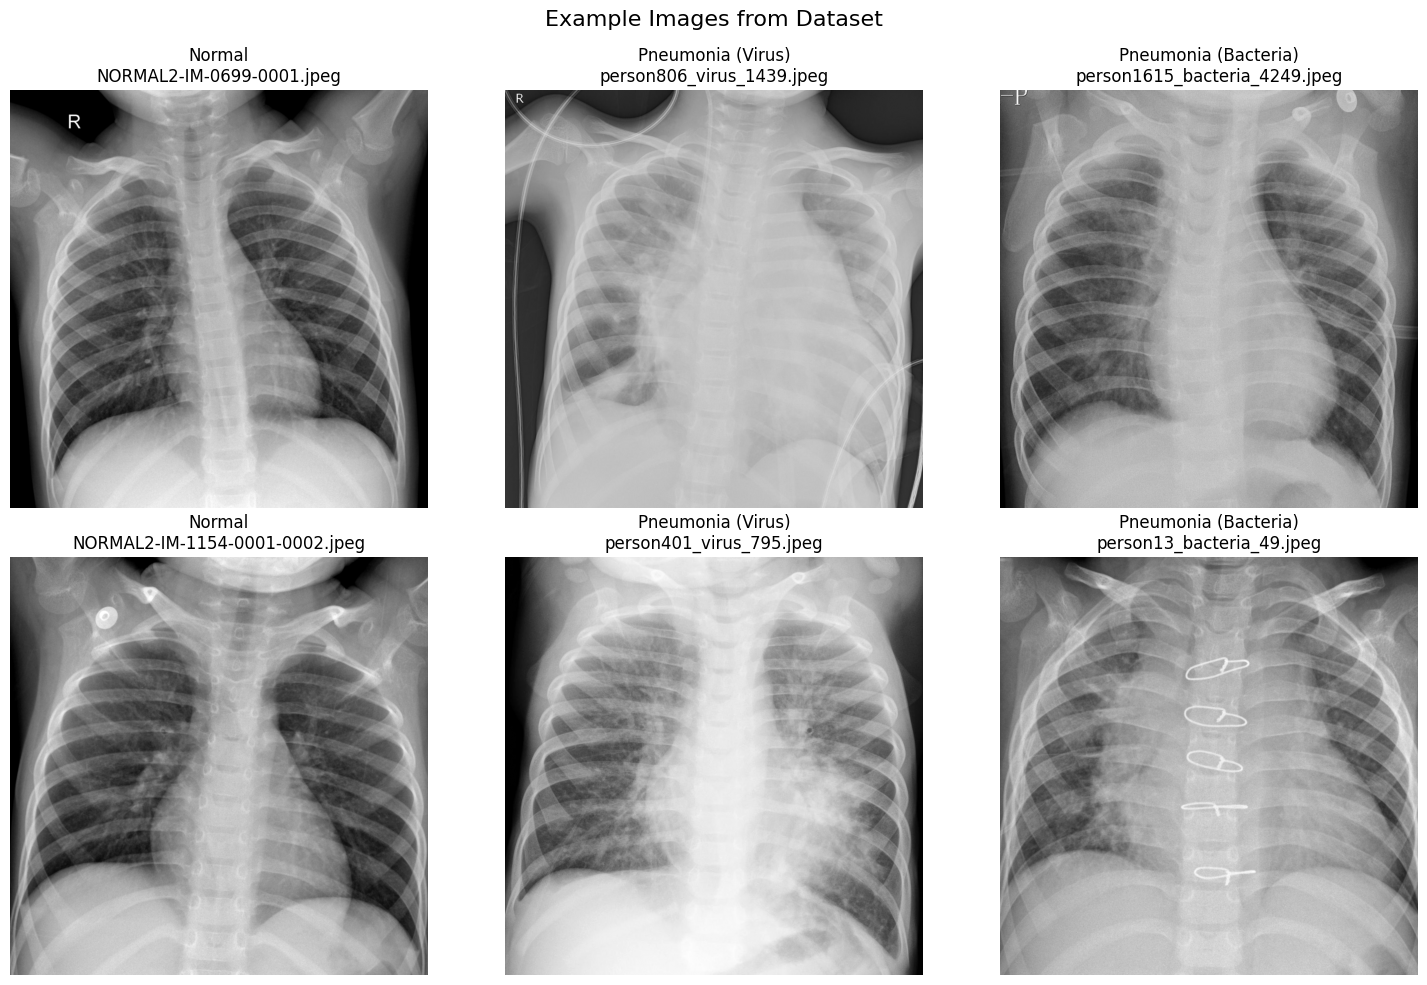

In [11]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import numpy as np

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Example Images from Dataset', fontsize=16)

# Function to get random images with similar aspect ratios but different content
def get_diverse_similar_ratio_images(directory, count=2, target_ratio=None):
    files = os.listdir(directory)
    
    # If no target ratio is provided, use a common medical image ratio
    if target_ratio is None:
        target_ratio = 1.0  # Square aspect ratio as default
    
    # Find images with similar aspect ratios
    image_info = []
    for file in files:
        img_path = os.path.join(directory, file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                aspect_ratio = width / height
                # Calculate how close this ratio is to target
                ratio_diff = abs(aspect_ratio - target_ratio)
                image_info.append((img_path, ratio_diff, aspect_ratio, file))
        except:
            continue
    
    # Sort by similarity to target aspect ratio
    image_info.sort(key=lambda x: x[1])
    
    # Take images from different parts of the sorted list to ensure diversity
    selected = []
    step = max(1, len(image_info) // (count * 3))
    indices = [i * step for i in range(count * 2)]
    indices = indices[:count]
    
    for idx in indices:
        if idx < len(image_info):
            selected.append(image_info[idx][0])
    
    while len(selected) < count and len(image_info) > 0:
        selected.append(image_info[0][0])
        image_info.pop(0)
    
    return selected

# Get normal images with similar aspect ratios
normal_train_samples = get_diverse_similar_ratio_images(train_normal_path, 2)

# Calculate the average aspect ratio from selected normal images
avg_aspect_ratio = 0
for img_path in normal_train_samples:
    with Image.open(img_path) as img:
        width, height = img.size
        avg_aspect_ratio += width / height
avg_aspect_ratio /= len(normal_train_samples)

# Filter pneumonia images by type
virus_files = [os.path.join(train_pneumonia_path, f) for f in train_pneumonia_files if 'virus' in f.lower()]
bacteria_files = [os.path.join(train_pneumonia_path, f) for f in train_pneumonia_files if 'bacteria' in f.lower()]

# Get diverse virus and bacteria images with similar aspect ratios to the normal images
virus_samples = get_diverse_similar_ratio_images(train_pneumonia_path, 2, avg_aspect_ratio)
bacteria_samples = get_diverse_similar_ratio_images(train_pneumonia_path, 2, avg_aspect_ratio)

# Ensure virus samples are actually virus images
virus_samples = []
virus_candidates = get_diverse_similar_ratio_images(train_pneumonia_path, 10, avg_aspect_ratio)
for img_path in virus_candidates:
    if 'virus' in os.path.basename(img_path).lower():
        virus_samples.append(img_path)
        if len(virus_samples) == 2:
            break

# Ensure bacteria samples are actually bacteria images
bacteria_samples = []
bacteria_candidates = get_diverse_similar_ratio_images(train_pneumonia_path, 10, avg_aspect_ratio)
for img_path in bacteria_candidates:
    if 'bacteria' in os.path.basename(img_path).lower():
        bacteria_samples.append(img_path)
        if len(bacteria_samples) == 2:
            break

# Plot the images
titles = ['Normal', 'Pneumonia (Virus)', 'Pneumonia (Bacteria)']
sample_sets = [normal_train_samples, virus_samples, bacteria_samples]

TARGET_HEIGHT = 1024  # Fixed height for all images
TARGET_WIDTH = 1024   # Fixed width for all images

for col, (title, samples) in enumerate(zip(titles, sample_sets)):
    for row, img_path in enumerate(samples):
        # Open and convert to grayscale
        img = Image.open(img_path).convert('L')
        width, height = img.size
        
        # Calculate scaling factor based on target height
        scale_factor = TARGET_HEIGHT / height
        new_width = int(width * scale_factor)
        
        # Resize image to match target height while maintaining aspect ratio
        img = img.resize((new_width, TARGET_HEIGHT), Image.LANCZOS)
        
        # Create a new black background image
        padded_img = Image.new('L', (TARGET_WIDTH, TARGET_HEIGHT), 0)
        
        # Calculate padding to center the image
        x_offset = (TARGET_WIDTH - new_width) // 2
        
        # Paste the resized image onto the padded background
        padded_img.paste(img, (x_offset, 0))
        
        # Display the padded image
        axes[row, col].imshow(padded_img, cmap='gray')
        axes[row, col].set_title(f"{title}\n{os.path.basename(img_path)}")
        axes[row, col].axis('off')
        
        # Force aspect ratio to be equal
        axes[row, col].set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### Q1.2

yes, normal looks clean, pneumonia virus is a lot blurrier, and white spots

### Q1.3

Class Imbalance

### Q1.4

Resolve Class Imbalance. 
Data Augmentation
Normalization
Bring to one standard size. 